In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from tqdm import tqdm_notebook
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
# import networkx as nx

In [4]:
np.random.seed(0) # setting the seed in order to make it fixed

In [5]:
# Doing data related implementations
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [6]:
# Train and testing dataset which have been flattened
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


## Training the VAE

In [7]:
original_dimensions = x_train.shape[1]
hidden_layer_size = 512
batch_size = 128
latent_dim = 2
epochs = 75

In [8]:
# Input fed to the autoencoder is of the form of the batch size and the dimension of the image
inputs = Input(shape=(original_dimensions,), name='encoder_input')
h = Dense(hidden_layer_size, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='g_mean')(h)
z_log_sigma = Dense(latent_dim, name='g_variance')(h)

W0828 22:52:45.288957 4387399104 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 22:52:45.321424 4387399104 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 22:52:45.325769 4387399104 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [9]:
def parametrization(args):
    # REPARAMETRIZATION TRICK
    m, v = args
    epsilon = tf.random.normal(shape=(2,))
    return m + K.exp(0.5 * v) * epsilon

In [10]:
# Get the combined z value from the function using the mean and sigma learnt by the autoencoder
z = Lambda(parametrization)([z_mean, z_log_sigma])

In [11]:
decoder_h = Dense(hidden_layer_size, activation='relu', name='decode_intermediate')
decoder_mean = Dense(original_dimensions, activation='sigmoid', name='decode_full')

In [12]:
# Same dimensions of the layers as the encoders but takes in the opposite way - as the autoencoder should
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
# encoder, from inputs to latent space
encoder = Model(inputs, z)

In [13]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)
# end-to-end autoencoder - defining the input and output points
vae = Model(inputs, x_decoded_mean)

In [14]:
def total_loss(x, x_decoded_mean):
    rcons_loss = binary_crossentropy(x, x_decoded_mean)
    rcons_loss *= original_dimensions
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return rcons_loss + kl_loss

vae.compile(optimizer='adam', loss=total_loss)

W0828 22:52:47.799899 4387399104 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 22:52:47.843001 4387399104 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3657: The name tf.log is deprecated. Please use tf.math.log instead.

W0828 22:52:47.850075 4387399104 deprecation.py:323] From /Users/harshdeep/final3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
x_decoded_mean.shape

TensorShape([Dimension(None), Dimension(784)])

In [16]:
# Fit the model to the data but labels and data would be the same since it is a generative model
# vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae.fit(x_train,x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, x_test))

W0828 22:52:49.048154 4387399104 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/75
60000/60000 [==============================] - 17s 275us/step - loss: 195.3887 - val_loss: 170.6774
Epoch 2/75
60000/60000 [==============================] - 16s 267us/step - loss: 168.6076 - val_loss: 164.5760
Epoch 3/75
60000/60000 [==============================] - 14s 225us/step - loss: 163.4753 - val_loss: 162.4014
Epoch 4/75
60000/60000 [==============================] - 14s 239us/step - loss: 161.0567 - val_loss: 159.9452
Epoch 5/75
60000/60000 [==============================] - 13s 223us/step - loss: 159.4022 - val_loss: 158.1609
Epoch 6/75
60000/60000 [==============================] - 15s 248us/step - loss: 157.8030 - val_loss: 156.7938
Epoch 7/75
60000/60000 [==============================] - 15s 243us/step - loss: 156.5121 - val_loss: 156.3145
Epoch 8/75
60000/60000 [==============================] - 15s 251us/step - loss: 155.3507 - val_loss: 154.7754
Epoch 9/75
60000/60000 [==============================] - 15s 

Epoch 74/75
60000/60000 [==============================] - 11s 182us/step - loss: 141.4608 - val_loss: 147.4165
Epoch 75/75
60000/60000 [==============================] - 11s 182us/step - loss: 141.5783 - val_loss: 146.9796


In [17]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [18]:
# display a 2D manifold of the digits
n = 15  # number of digits to be generated
digit_size = 28 # Size of the digits
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        
        # Looking in the Z-sample space with the dimensions for x and y
        # 0.2 is basically trying to bound the set of items you can intake - so it is a parameter
        z_sample = np.array([[xi, yi]]) * 0.2
        # Put the values of the Z sample space in the decoder
        x_decoded = generator.predict(z_sample)
        # Reshape the digit into 28*28 - 2D thingy!
        digit = x_decoded[0].reshape(digit_size, digit_size)
        # Assign the digit into the output set 
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

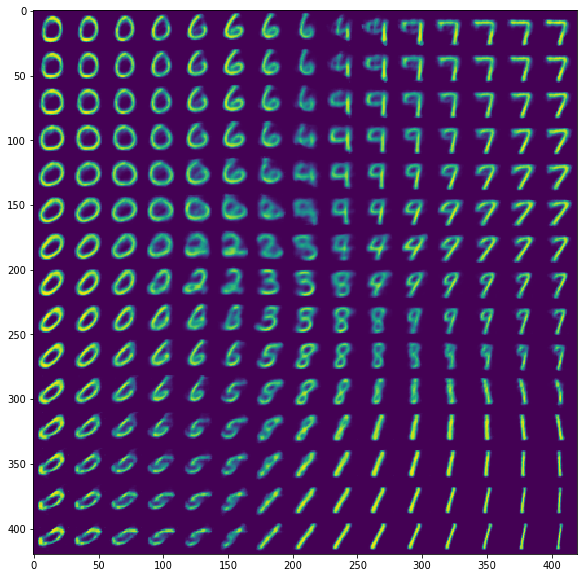

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

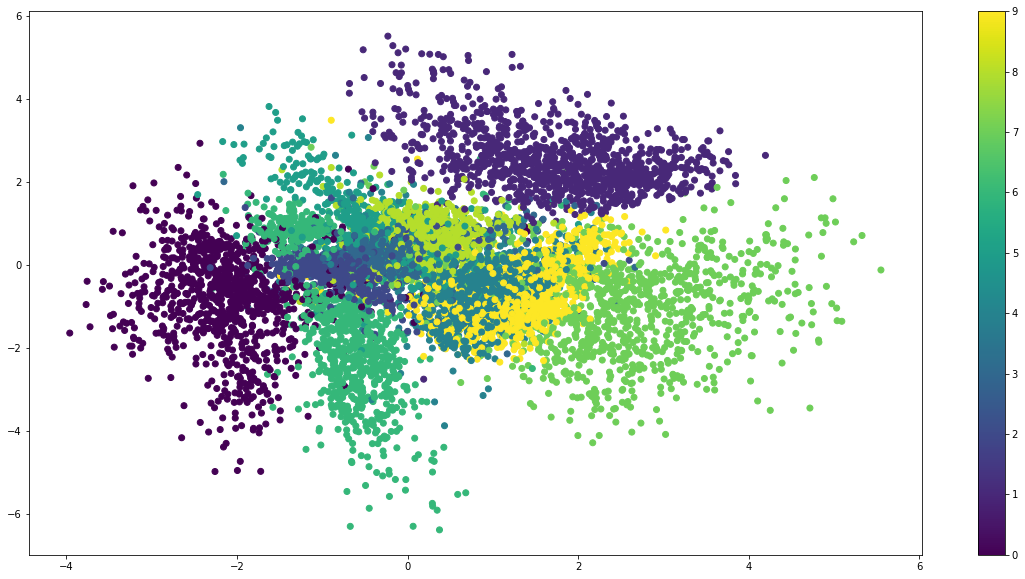

In [20]:
# Plotting the graph for consistency and looking where does each class belong
plt.figure(figsize=(20, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [48]:
import keras.backend as K
from sklearn.neighbors import NearestNeighbors

In [57]:
sess = tf.Session()

In [58]:
sess.run(tf.global_variables_initializer())

In [59]:
class RiemannianMetricTest(object):
    def __init__(self, decoder_input, decoder_output, session):
        self.decoder_output = decoder_output
        self.decoder_input = decoder_input
        self.session = session

    def create_metrics(self):
        # the metric tensor
        output_dim = self.decoder_output.shape[1].value
        # Finding the gradient of costs with respect to input
        J = [
            tf.gradients(self.decoder_output[:, _], self.decoder_input)[0] 
            for _ in tqdm_notebook(range(output_dim))
        ]
        J = tf.stack(J, axis=1)
        self.J = J
        # Riemannian metric
        G = tf.transpose(J, [0, 2, 1]) @ J 
        self.G = G

    def get_riemannian_distance(self, z1, z2):
        n_steps = 5
        t = np.linspace(0, 1, n_steps)
        dt = t[1] - t[0]
        print('These are the points', z1, z2)
        # Get all the n_steps of equidistant points
        the_line = np.vstack([_ * z1 + (1 - _) * z2 for _ in t])
        G_eval = self.session.run(self.G, feed_dict={self.decoder_input: the_line})
        # Calculating the observation space distance between 2 points in the space
        # @ operator is a shorthand for matrix multiplication
        L_discrete = np.sqrt((z1-z2) @ G_eval @ (z1-z2).T)
        L_discrete = L_discrete.flatten()
        distance = np.sum(dt * L_discrete)
        return distance

In [60]:
rmetric = RiemannianMetricTest(
    generator.input, generator.output, sess
)

In [61]:
rmetric.create_metrics() # Construct the initial G and J graph

In [64]:
class RiemannianTree(object):
    def __init__(self, distance_metric):
        self.n_nodes = int(x_test_encoded.shape[0] / 10)
        self.distance_metric = distance_metric
        self.latent = x_test_encoded
        
    def create_riemannian_graph(self, n_neighbors):
        """
        Makes a KD Tree by taking into the riemannian distance.
        """
        sampled_indices = np.random.randint(10000, size=(self.n_nodes,))
        sampled_nodes = self.latent[sampled_indices]
        
        # Make a KD-Tree and fit it to the sampled nodes and set the distances 
        neigh = NearestNeighbors(
            n_neighbors=n_neighbors,
            algorithm='ball_tree', leaf_size=10, metric=self.distance_metric.get_riemannian_distance)
        neigh.fit(sampled_nodes)

In [65]:
rtree = RiemannianTree(rmetric)

In [66]:
rtree.create_riemannian_graph(10)

These are the points [ 0.2918201  -0.02533446] [-0.14050175  1.16452754]
These are the points [ 0.2918201  -0.02533446] [-2.04459476 -1.05717242]
These are the points [ 0.2918201  -0.02533446] [-0.45388585  0.13440065]
These are the points [ 0.2918201  -0.02533446] [-0.52048445  5.17709827]
These are the points [ 0.2918201  -0.02533446] [1.29685533 0.04060319]
These are the points [ 0.2918201  -0.02533446] [-0.66662705 -1.01911533]
These are the points [ 0.2918201  -0.02533446] [1.58074522 1.98063362]
These are the points [ 0.2918201  -0.02533446] [-1.10752726 -0.13164786]
These are the points [ 0.2918201  -0.02533446] [-0.06637716  0.20958717]
These are the points [ 0.2918201  -0.02533446] [ 0.29104778 -2.00886202]
These are the points [ 0.2918201  -0.02533446] [-1.07366943  0.85387075]
These are the points [ 0.2918201  -0.02533446] [-0.79900259 -0.06168675]
These are the points [ 0.2918201  -0.02533446] [-0.26536208 -0.16907175]
These are the points [ 0.2918201  -0.02533446] [ 2.9010

These are the points [ 0.2918201  -0.02533446] [0.42008305 0.52086496]
These are the points [ 0.2918201  -0.02533446] [0.61342627 0.49950716]
These are the points [ 0.2918201  -0.02533446] [ 0.50911093 -1.16316295]
These are the points [ 0.2918201  -0.02533446] [-0.32081437 -0.06790807]
These are the points [ 0.2918201  -0.02533446] [0.49568886 0.28545326]
These are the points [ 0.2918201  -0.02533446] [ 1.17625713 -0.81037408]
These are the points [ 0.2918201  -0.02533446] [0.10169009 0.12847264]
These are the points [ 0.2918201  -0.02533446] [ 1.24998355 -1.15011275]
These are the points [ 0.2918201  -0.02533446] [-1.19487619  1.04984188]
These are the points [ 0.2918201  -0.02533446] [2.93345571 0.55856788]
These are the points [ 0.2918201  -0.02533446] [-3.4841311  -1.22803628]
These are the points [ 0.2918201  -0.02533446] [-0.3940208   0.01136683]
These are the points [ 0.2918201  -0.02533446] [-0.88124961 -0.43202707]
These are the points [ 0.2918201  -0.02533446] [ 1.08050144 -

These are the points [ 0.2918201  -0.02533446] [-0.29156321  0.57644248]
These are the points [ 0.2918201  -0.02533446] [-0.79241347 -1.19139576]
These are the points [ 0.2918201  -0.02533446] [ 1.07575226 -0.59631169]
These are the points [ 0.2918201  -0.02533446] [0.80187976 0.71719861]
These are the points [ 0.2918201  -0.02533446] [ 1.47379363 -1.03632808]
These are the points [ 0.2918201  -0.02533446] [-1.30000484 -0.52445543]
These are the points [ 0.2918201  -0.02533446] [-0.95439744  0.94650352]
These are the points [ 0.2918201  -0.02533446] [ 0.4387573  -1.38357961]
These are the points [ 0.2918201  -0.02533446] [-0.79900259 -0.06168675]
These are the points [ 0.2918201  -0.02533446] [-0.28912243  0.62845558]
These are the points [ 0.2918201  -0.02533446] [0.46055824 0.13984221]
These are the points [ 0.2918201  -0.02533446] [0.17916004 0.48370904]
These are the points [ 0.2918201  -0.02533446] [ 0.42620277 -1.1009289 ]
These are the points [ 0.2918201  -0.02533446] [-0.726822

These are the points [ 0.2918201  -0.02533446] [-2.74198747 -1.22264934]
These are the points [ 0.2918201  -0.02533446] [ 0.88935125 -2.13134766]
These are the points [ 0.2918201  -0.02533446] [2.62878084 0.9140681 ]
These are the points [ 0.2918201  -0.02533446] [-1.0241946   1.72619641]
These are the points [ 0.2918201  -0.02533446] [-0.41906348  0.07000185]
These are the points [ 0.2918201  -0.02533446] [-1.45337677  0.74017739]
These are the points [ 0.2918201  -0.02533446] [ 1.26828051 -0.57144219]
These are the points [ 0.2918201  -0.02533446] [1.39510989 1.27956784]
These are the points [ 0.2918201  -0.02533446] [1.62078094 2.77485585]
These are the points [ 0.2918201  -0.02533446] [2.44914651 1.67131174]
These are the points [ 0.2918201  -0.02533446] [ 1.38645566 -1.58298075]
These are the points [ 0.2918201  -0.02533446] [ 0.81466657 -0.79809386]
These are the points [ 0.2918201  -0.02533446] [-0.39039007  0.15713368]
These are the points [ 0.2918201  -0.02533446] [-1.99277198

These are the points [ 0.2918201  -0.02533446] [ 2.4598074  -0.43788308]
These are the points [ 0.2918201  -0.02533446] [-2.44354272 -0.53528368]
These are the points [ 0.2918201  -0.02533446] [-0.35516968  0.60552961]
These are the points [ 0.2918201  -0.02533446] [-1.72983193 -0.21216652]
These are the points [ 0.2918201  -0.02533446] [ 3.82670426 -0.42824182]
These are the points [ 0.2918201  -0.02533446] [-0.37843078  0.19380641]
These are the points [ 0.2918201  -0.02533446] [-1.59174263 -0.71744823]
These are the points [ 0.2918201  -0.02533446] [ 1.17742586 -0.40659076]
These are the points [ 0.2918201  -0.02533446] [-1.66650021  0.56906271]
These are the points [ 0.2918201  -0.02533446] [0.76504546 3.87416267]
These are the points [ 0.2918201  -0.02533446] [-2.641078    0.18072192]
These are the points [ 0.2918201  -0.02533446] [0.68957222 0.21976218]
These are the points [ 0.2918201  -0.02533446] [-0.35007256  0.04083852]
These are the points [ 0.2918201  -0.02533446] [ 0.8346

These are the points [ 0.2918201  -0.02533446] [-0.31090242 -2.54291153]
These are the points [ 0.2918201  -0.02533446] [ 1.99477899 -0.74156851]
These are the points [ 0.2918201  -0.02533446] [0.43398601 2.36849141]
These are the points [ 0.2918201  -0.02533446] [0.98404288 0.72772449]
These are the points [ 0.2918201  -0.02533446] [0.64611286 0.15811659]
These are the points [ 0.2918201  -0.02533446] [-0.47256956  0.68499172]
These are the points [ 0.2918201  -0.02533446] [2.401438   2.21480393]
These are the points [ 0.2918201  -0.02533446] [2.62991476 1.70224237]
These are the points [ 0.2918201  -0.02533446] [-2.87494469 -1.47644281]
These are the points [ 0.2918201  -0.02533446] [-2.16795993 -1.60463786]
These are the points [ 0.2918201  -0.02533446] [-2.70171285 -1.48109376]
These are the points [ 0.2918201  -0.02533446] [1.96094298 1.42129028]
These are the points [ 0.2918201  -0.02533446] [2.14554095 1.7629739 ]
These are the points [ 0.2918201  -0.02533446] [ 1.51753914 -1.41

These are the points [ 0.2918201  -0.02533446] [ 1.07282543 -0.58247632]
These are the points [ 0.2918201  -0.02533446] [0.25104567 0.72432613]
These are the points [ 0.2918201  -0.02533446] [-0.24635176  0.31317139]
These are the points [ 0.2918201  -0.02533446] [ 1.78872085 -0.81261134]
These are the points [ 0.2918201  -0.02533446] [2.0806675  3.32945561]
These are the points [ 0.2918201  -0.02533446] [-1.85627604 -0.71888328]
These are the points [ 0.2918201  -0.02533446] [ 0.02524754 -0.19658363]
These are the points [ 0.2918201  -0.02533446] [2.99664593 2.4134841 ]
These are the points [ 0.2918201  -0.02533446] [-0.79364449 -0.30175841]
These are the points [ 0.2918201  -0.02533446] [-0.45536202  0.35196576]
These are the points [ 0.2918201  -0.02533446] [-0.48001677  0.66991776]
These are the points [ 0.2918201  -0.02533446] [ 0.43275985 -1.34790814]
These are the points [ 0.2918201  -0.02533446] [ 1.44230378 -0.33885393]
These are the points [ 0.2918201  -0.02533446] [-0.855309

These are the points [ 0.2918201  -0.02533446] [0.56819457 0.83107221]
These are the points [ 0.2918201  -0.02533446] [ 0.74399674 -1.58940339]
These are the points [ 0.2918201  -0.02533446] [-0.30505458 -0.14852539]
These are the points [ 0.2918201  -0.02533446] [-0.5803833  -0.20472108]
These are the points [ 0.2918201  -0.02533446] [-0.16298269  0.05846821]
These are the points [ 0.2918201  -0.02533446] [-1.16154599  0.76191717]
These are the points [ 0.2918201  -0.02533446] [ 0.81466657 -0.79809386]
These are the points [ 0.2918201  -0.02533446] [1.76490009 3.62688088]
These are the points [ 0.2918201  -0.02533446] [-0.11766851 -0.48398268]
These are the points [ 0.2918201  -0.02533446] [-2.24418163  0.47439942]
These are the points [ 0.2918201  -0.02533446] [-0.50354207  0.23745917]
These are the points [ 0.2918201  -0.02533446] [ 1.14369607 -1.42645252]
These are the points [ 0.2918201  -0.02533446] [-1.14670336 -0.93397897]
These are the points [ 0.2918201  -0.02533446] [ 1.6591

These are the points [ 0.2918201  -0.02533446] [1.90634322 0.39539438]
These are the points [ 0.2918201  -0.02533446] [-0.2075851   0.22059701]
These are the points [ 0.2918201  -0.02533446] [-0.45849252 -2.0178144 ]
These are the points [ 0.2918201  -0.02533446] [ 0.4231025 -0.1842739]
These are the points [ 0.2918201  -0.02533446] [-0.38759375  0.78967369]
These are the points [ 0.2918201  -0.02533446] [ 1.61643517 -0.31509587]
These are the points [ 0.2918201  -0.02533446] [-2.067523  0.625669]
These are the points [ 0.2918201  -0.02533446] [-0.64731568 -0.17185344]
These are the points [ 0.2918201  -0.02533446] [0.80187976 0.71719861]
These are the points [ 0.2918201  -0.02533446] [0.39258593 0.26108602]
These are the points [ 0.2918201  -0.02533446] [ 2.36025596 -1.75709963]
These are the points [ 0.2918201  -0.02533446] [-0.36125752 -0.6515727 ]
These are the points [ 0.2918201  -0.02533446] [-0.79855847 -0.03009422]
These are the points [ 0.2918201  -0.02533446] [ 1.40312183 -1.

KeyboardInterrupt: 